In [1]:
import cv2
import numpy as np
from astropy.io import fits
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
from astropy.io import fits
from skimage.transform import hough_line, hough_line_peaks
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from skimage.draw import line
from skimage import data
from timeit import default_timer as timer
from scipy.ndimage.filters import gaussian_filter
import numpy.ma as ma
import glob
import os

In [6]:
#Directory where smaps of splitted images and full image is stored
dataset = 'snr2'
image_folder_smaps = '/lustre/fs23/group/icecube/azenin/last/images/last_streaks/last_' + dataset + '_part/'
image_folder_image = '/lustre/fs23/group/icecube/azenin/last/images/last_streaks/last_' + dataset + '_new.fit'
full_image_file = fits.open(image_folder_image)
full_image = full_image_file[0].data
#create empty mask for full image
mask = np.zeros((full_image.shape[0],full_image.shape[1]))
xmax, ymax = mask.shape
#properties of subimages and internal stuff
x_parts = 5
y_parts = 10
smap_file = fits.open(image_folder_smaps + 'last_' + dataset + '_x0y0_smap.fit')
smap = smap_file[0].data
cutoff_smaps = np.zeros((x_parts, y_parts, smap.shape[0], smap.shape[1]))
lines_sample = []
global_lines = []

In [7]:
#IMPORTANT: WE NEED PSF (in pixel size), 
psf=15

In [20]:
#Load smaps from splitted input image, calculate cutoff
line_array = np.zeros((x_parts, y_parts, 2))
for i in range(x_parts):
    for j in range(y_parts):
        filename = image_folder_smaps + 'last_' + dataset + '_x%d' % i + 'y%d' % j + '_smap.fit' 
        with fits.open(filename) as hdul:
            image=hdul[0].data
#             image[np.isnan(image)] = 0
#             histogram = image.flatten()
#             try:
#                 histogram=histogram[histogram < 0]
#                 quantile = np.quantile(histogram, 0.32)
#             except:
#                 quantile = 0
#             cutoff = abs(quantile)
#             image[image < cutoff] = 0
            cutoff_smaps[i][j] = image
            """
            plt.imshow(image, cmap='gray')
            plt.colorbar()
            plt.show()
            """

In [26]:
#Do canny and hough for line finding
# Anatolii:
# Changed this part to make it append global lines instead 
for i in range(cutoff_smaps.shape[0]):
    for j in range(cutoff_smaps.shape[1]):
        edges = canny(cutoff_smaps[i][j], psf)
        lines = list(probabilistic_hough_line(edges, threshold=10, line_length=int(100*psf), line_gap=int(3*psf)))
        for k in range(len(lines)):
            lines[k] = list(lines[k])
            lines[k][0] = list(lines[k][0])
            lines[k][1] = list(lines[k][1])
#                 print('wtf')
#             print('not modified: %d, %d' % (lines[k][0][0], lines[k][0][1]))
            lines[k][0][0] += j*smap.shape[1]
            lines[k][1][0] += j*smap.shape[1]
            lines[k][0][1] += i*smap.shape[0]
            lines[k][1][1] += i*smap.shape[0]
#             print("modified: %d, %d; i = %d, j = %d" % (lines[k][0][0], lines[k][0][1], i, j))
#             if(lines[k][0][0] < (i+1) * smap.shape[0] and lines[k][0][1] < (j+1) * smap.shape[1] and lines[k][1][0] < (i+1) * smap.shape[0] and lines[k][1][1] < (j+1) * smap.shape[1]):
            global_lines.append(lines[k])
#output is list of arrays, where start and end-points of found lines are listed
#not a list of tuples or lists?
print(len(global_lines))

52014


In [24]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(full_image, cmap=cm.gray, norm=LogNorm())
ax[0].set_title('Input image')

ax[1].imshow(full_image * 0)
for line in global_lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))
#ax[1].set_xlim((0,full_image.shape[1]))
#ax[1].set_ylim((full_image.shape[0], 0))
ax[1].set_title('Probabilistic Hough')

for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()
#Here we need the code to get the global coordinates for the found lines in lines_sample
# line_array = np.zeros((x_parts, y_parts, 2))
# for i in range(x_parts):
#     for j in range(y_parts):
#         line_array[i][j][0] = lines[i*y_parts+j][0]
#         line_array[i][j][1] = lines[i*y_parts+j][1]
#Output should be an list of all global line coordinates (global_lines)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

91.82545027788728


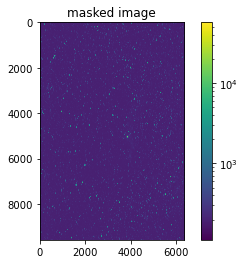

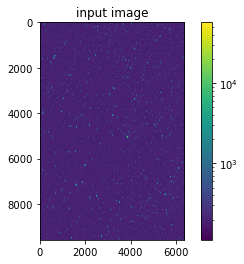

In [32]:
#Fold mask with gaussian to get line width (PSF-based)
mask = gaussian_filter(mask, sigma=int(2*psf))
#Get masked image
masked_image = ma.masked_where(mask >0, full_image)
end = timer()
print(end - start)
plt.imshow(masked_image, norm=LogNorm())
plt.colorbar()
plt.title("masked image")
plt.show()
plt.imshow(full_image, norm=LogNorm())
plt.colorbar()
plt.title("input image")
plt.show()

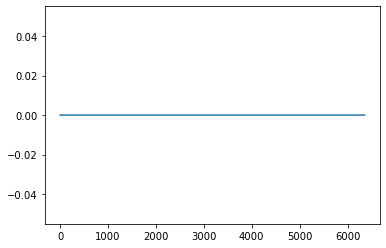

In [24]:
# plt.imshow(mask)
plt.plot(mask[0, :])

In [13]:
%matplotlib widget
plt.imshow(cutoff_smaps[1][1])
plt.colorbar()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [19]:
full_smap_file = fits.open("/lustre/fs23/group/icecube/azenin/last/images/snr2_smap.fit")
full_smap = full_smap_file[0].data
image = full_smap
histo = image.flatten()
try:
    histo=histo[histogram < 0]
    quantile = np.quantile(histo, 0.32)
except:
    quantile = 0
cutoff = abs(quantile)
image[image < cutoff] = 0
plt.imshow(image)
plt.colorbar()
plt.show()
